# Welcome to the HNN-Core ERP tutorial!
In order to understand the workflow and initial parameter sets provided with this tutorial, we must first briefly describe prior studies that led to the creation of the provided data and evoked response parameter set that you will work with. This tutorial is based on results from our 2007 study where we recorded and simulated tactile evoked responses source localized to the primary somatosensory cortex (SI) [1].

In our 2007 study, we investigated the early evoked activity (0-175 ms) elicited by a brief tap to the D3 digit and source localized to an an equivalent current dipole in the contralateral hand area of the primary somatosensory cortex (SI) [1]. The strength of the tap was set at either suprathreshold (100% detection probability) or perceptual  threshold (50% detection) levels (see Figure 1, left panel below). Note, to be precise, this data represents source localized event related field (ERF) activity because it was collected using MEG. We use the terminology ERP for simplicity, since the primary current dipoles generating evoked fields and potentials are the same.

We found that we could reproduce evoked responses that accurately reflected the recorded waveform in our neocortical model from a layer specific sequence of exogenous excitatory synaptic drive to the local SI circuit, see Figure 1right panel below. This drive consisted of “feedforward” / proximal input at ~25 ms post-stimulus, followed by “feedback” / distal input at ~60 ms, followed by a subsequent “feedforward” / proximal input at ~125 ms (Gaussian distribution of input times on each simulated trial). This sequence of drive generated spiking activity and intracellular dendritic current flow in the pyramidal neuron dendrites to reproduce the current dipole signal. This sequence of drive can be interpreted as initial “feedforward” input from the lemniscal thalamus, followed by “feedback” input from higher order cortex or non-lemniscal thalamus, followed by a re-emergent leminsical thalamic drive. Intracranial recordings in non-human primates motivated and supported this assumption [2].

In our model, the exogenous driving inputs were simulated as predefined trains of action potentials (pre-synaptic spikes) that activated excitatory synapses in the local cortical circuit in proximal and distal projection patterns (i.e. feedforward, and feedback, respectively, as shown schematically in Figure 1 right). The number, timing and strength (post-synaptic conductance) of the driving spikes were manually adjusted in the model until a close representation of the data was found (all other model parameters were tuned and fixed based on the morphology, physiology and connectivity within layered neocortical circuits [1]. Note, a scaling factor was applied to net dipole output to match to the magnitude of the recorded ERP data and used to predict the number of neurons contributing to the recorded ERP (purple circle, Figure 1, right panel). The dipole units were in nAm, with a one-to-one comparison between data and model output due to the biophysical detail in our model.

<div class="stylefig">

### Figure 1

<a href="https://raw.githubusercontent.com/jonescompneurolab/hnn-tutorials/master/erp/images/image8.png"><img class="imgcenter100" src="https://raw.githubusercontent.com/jonescompneurolab/hnn-tutorials/master/erp/images/image8.png" alt="image8" style="max-width:650px;"/></a>

<p style="text-align:justify;"> Adapted from Jones et al. 2007 [1]. Comparison of SI evoked response in experiment and neural model simulation. Left: MEG data showing tactile evoked response (ERP) source localized to the hand area of SI. Red: suprathreshold stimulation; Blue: Threshold stimulation (avg. n=100 trials). Right: Neural model simulation depicting proximal/distal inputs needed to replicate the ERP waveform (avg. n=25 trials) </p>
</div>

In summary, to simulate the SI evoked response, a sequence of exogenous excitatory synaptic drive was simulated (by creating presynaptic spikes that activate layer specific synapses in the neocortical network) consisting of proximal drive at ~25 ms, followed by distal drive at ~60 ms, followed by a second proximal drive at ~122 ms. Given this background information, we can now walk you through the steps of simulating a similar ERP, using a subset of the data shown in Figure 1.

### References
1. Jones, S. R., Pritchett, D. L., Stufflebeam, S. M., Hämäläinen, M. & Moore, C. I. Neural correlates of tactile detection: a combined magnetoencephalography and biophysically based computational modeling study. J. Neurosci. 27, 10751–10764 (2007).

2. Cauller, L. J. & Kulics, A. T. The neural basis of the behaviorally relevant N1 component of the somatosensory-evoked potential in SI cortex of awake monkeys: evidence that backward cortical projections signal conscious touch sensation. Exp. Brain Res. 84, 607–619 (1991).

## 1. Importing python libraries and loading data

In [1]:
import os.path as op


import numpy as np
import matplotlib.pyplot as plt

from hnn_core import jones_2009_model, simulate_dipole, MPIBackend, JoblibBackend, average_dipoles
from hnn_core.viz import plot_dipole, plot_tfr_morlet

Let's retrieve and load the experimental dipole

In [2]:
from urllib.request import urlretrieve
data_url = ('https://raw.githubusercontent.com/jonescompneurolab/hnn/master/'
            'data/MEG_detection_data/yes_trial_S1_ERP_all_avg.txt')
urlretrieve(data_url, 'yes_trial_S1_ERP_all_avg.txt')

('yes_trial_S1_ERP_all_avg.txt', <http.client.HTTPMessage at 0x1178b3b50>)

Then we read the dipole using ``hnn-core``

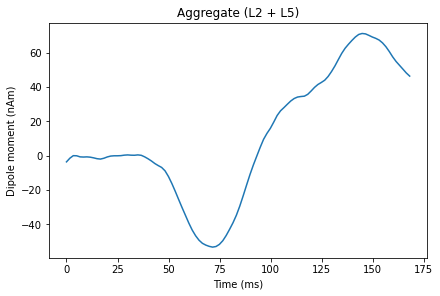

In [3]:
from hnn_core import read_dipole

exp_dpl = read_dipole('yes_trial_S1_ERP_all_avg.txt')
exp_dpl.plot();

## 2. Creating a network

Create network and visualize where cell somas are positioned in 3D space

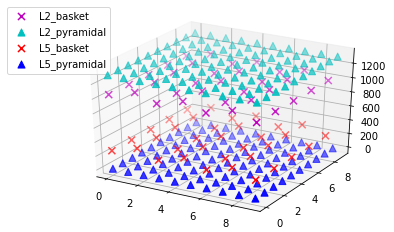

In [4]:
net = jones_2009_model()
net.plot_cells();

We can explore the network connectivity

In [65]:
net.connectivity[:2]

[L2_pyramidal -> L2_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'proximal'; receptor: 'nmda'
 weight: 0.0005; delay: 1.0; lamtha: 3.0
  ,
 L2_pyramidal -> L2_pyramidal
 cell counts: 100 srcs, 100 targets
 connection probability: 1.0 
 loc: 'proximal'; receptor: 'ampa'
 weight: 0.0005; delay: 1.0; lamtha: 3.0
  ]

The cell properties are also visible

In [66]:
net.cell_types['L5_pyramidal'].synapses

{'ampa': {'e': 0.0, 'tau1': 0.5, 'tau2': 5.0},
 'nmda': {'e': 0.0, 'tau1': 1.0, 'tau2': 20.0},
 'gabaa': {'e': -80.0, 'tau1': 0.5, 'tau2': 5.0},
 'gabab': {'e': -80.0, 'tau1': 1.0, 'tau2': 20.0}}

Our layer-5 pyramidal neurons have 9 compartments

In [67]:
net.cell_types['L5_pyramidal'].sections.keys()

dict_keys(['apical_trunk', 'apical_1', 'apical_2', 'apical_tuft', 'apical_oblique', 'basal_1', 'basal_2', 'basal_3', 'soma'])

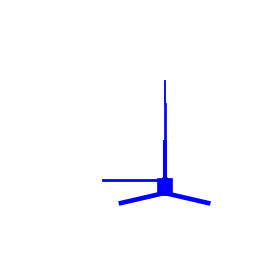

In [68]:
net.cell_types['L5_pyramidal'].plot_morphology();

We can see the parameters of a particular compartment

In [69]:
net.cell_types['L5_pyramidal'].sections['apical_trunk']

L=102.0, diam=10.2, cm=0.85, Ra=200.0

and the synapses on to this section

In [70]:
net.cell_types['L5_pyramidal'].sections['apical_trunk'].syns

['ampa', 'nmda', 'gabaa', 'gabab']

## 3. Adding drives and running a simulation

First, we add another proximal drive at around 26 ms. The proximal drive represents a feedforward input from the lemniscal thalamus.

In [71]:
weights_ampa_p1 = {'L2_basket': 0.08831, 'L2_pyramidal': 0.01525,
                   'L5_basket': 0.19934, 'L5_pyramidal': 0.00865}
synaptic_delays_prox = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                        'L5_basket': 1., 'L5_pyramidal': 1.}
# all NMDA weights are zero; pass None explicitly
net.add_evoked_drive(
    'evprox1', mu=26.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
    weights_nmda=None, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=4)



We can check the drives have been added by looking at

In [72]:
net.external_drives

{'evprox1': <External drive 'evprox1'
 drive class: evoked
 target cell types: ['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal']
 number of drive cells: 270
 cell-specific: True
 dynamic parameters:
 	mu: 26.61
 	sigma: 2.47
 	numspikes: 1>}

Then we add a distal drive at around 63 ms. This represents "feedback" input from higher-order cortex

In [73]:
weights_ampa_d1 = {'L2_basket': 0.006562, 'L2_pyramidal': .000007,
                   'L5_pyramidal': 0.142300}
weights_nmda_d1 = {'L2_basket': 0.019482, 'L2_pyramidal': 0.004317,
                   'L5_pyramidal': 0.080074}
synaptic_delays_d1 = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                      'L5_pyramidal': 0.1}
net.add_evoked_drive(
    'evdist1', mu=63.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=weights_nmda_d1, location='distal',
    synaptic_delays=synaptic_delays_d1, event_seed=4)

Finally, we add a second proximal drive at around 137 ms that represents a re-emergent lemniscal thalamic drive. 
Intracranial recordings in non-human primates motivated and supported this assumption [ref]

In [74]:
weights_ampa_p2 = {'L2_basket': 0.000003, 'L2_pyramidal': 1.438840,
                   'L5_basket': 0.008958, 'L5_pyramidal': 0.684013}

# all NMDA weights are zero; omit weights_nmda (defaults to None)
net.add_evoked_drive(
    'evprox2', mu=137.12, sigma=8.33, numspikes=1,
    weights_ampa=weights_ampa_p2, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=4)

Now, we simulate the dipole with just one trial for now

In [75]:
dpls = simulate_dipole(net, tstop=170., n_trials=1)

joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...


The simulation is a bit slow. If we want to speed it up, we can use MPI. It's a protocol that splits the simulation across neurons. You might need extra set up for this. See here (insert link to MPI installation)

In [76]:
# simulate dipole with a specific parallel backend (2 trials)
# we'll use MPIBackend for the remainder of this tutorial as it is the fastest
with MPIBackend(n_procs=4):
    dpls = simulate_dipole(net, tstop=170., n_trials=2)
    
# If you don't have the OpenMPI and mpi4py installed on you machine,
# you can alternatively use JoblibBackend (uncomment lines below)
# with JoblibBackend(n_jobs=2):
#    dpls = simulate_dipole(net, tstop=170., n_trials=2)

/Users/mainak/Documents/github_repos/hnn-core/hnn_core/parallel_backends.py:629: UserWarning: psutil not installed. Will run on single processor
  warn(f'{packages} not installed. Will run on single processor')


Backend will use 1 core. Running simulation without MPI
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Building the NEURON model
[Done]
running trial 2 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simu

## 4. Plotting and visualization

The simulation returns a list of dipoles with length equal to number of trials.

In [77]:
dpls

First we'll plot the raw waveform that is unsmoothed and unscaled

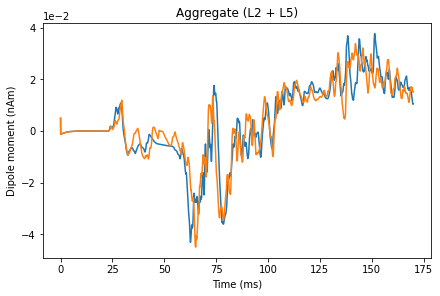

In [78]:
plot_dipole(dpls);

Now, note that we simulated a network of 10 x 10 Pyramidal cells but human cortex contains much more neurons and the MEG signals usually represent synchronous activation of at least ~50,000 Pyramidal neurons. Hence, we must scale the signal to match the source localized data. Averaging across so many neurons will also smooth the signal. Hence for a better comparison, we should smooth and scale

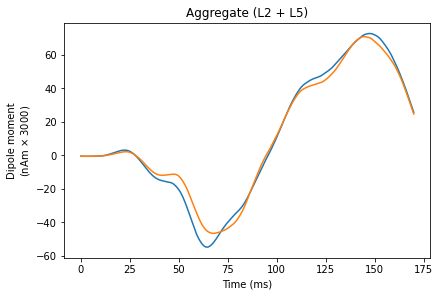

In [79]:
window_len, scaling_factor = 30, 3000
for dpl in dpls:
    dpl.smooth(window_len).scale(scaling_factor)
    
# plot again
fig = plot_dipole(dpls)

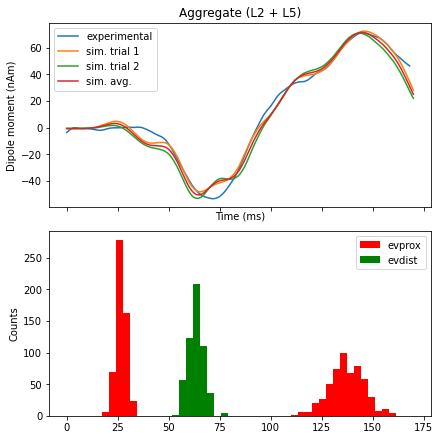

In [54]:
# compare simulated and experimental dipoles
# create matplotlib subplots on which to overlay hnn-core simulation plots
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)

# plot experimental dipole
exp_dpl.plot(ax=axes[0], show=False)

# plot both simulation trial dipoles and their avg
# note that there are two ways to plot a dipole: using the Dipole.plot() method and the plot_dipole() function!
plot_dipole(dpls, ax=axes[0], layer='agg', show=False)
average_dipoles(dpls).plot(ax=axes[0], show=False)
axes[0].legend(['experimental', 'sim. trial 1', 'sim. trial 2', 'sim. avg.'])

# finally, plot the input spike histogram
fig = net.cell_response.plot_spikes_hist(ax=axes[1],
                                         spike_types=['evprox', 'evdist'])

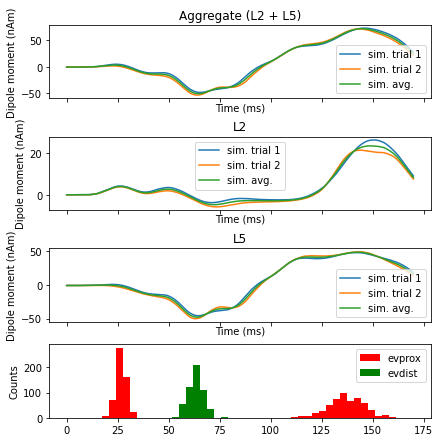

In [55]:
# plot layer-specific dipoles
# create matplotlib subplots on which to overlay hnn-core simulation plots
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)


# plot both simulation trial dipoles and their avg
avg_dpl = average_dipoles(dpls)
for idx, layer in enumerate(['agg', 'L2', 'L5']):
    
    
    plot_dipole(dpls, ax=axes[idx], layer=layer, show=False)
    plot_dipole(avg_dpl, ax=axes[idx], layer=layer, show=False)
    axes[idx].legend(['sim. trial 1', 'sim. trial 2', 'sim. avg.'])

# finally, plot the input spike histogram
fig = net.cell_response.plot_spikes_hist(ax=axes[3],
                                         spike_types=['evprox', 'evdist'])

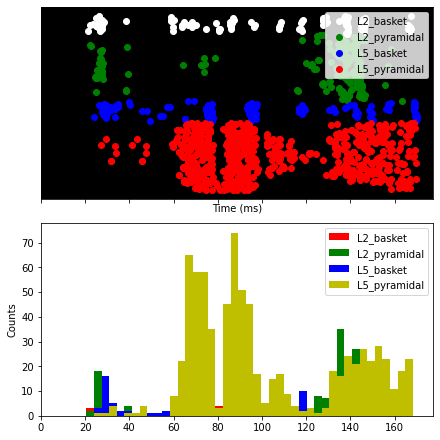

In [56]:
# plot spiking activity
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)
fig = net.cell_response.plot_spikes_raster(ax=axes[0], show=False)
fig = net.cell_response.plot_spikes_hist(ax=axes[1],
                                         spike_types=['L2_basket', 'L2_pyramidal', 'L5_basket', 'L5_pyramidal'],
                                         show=False)

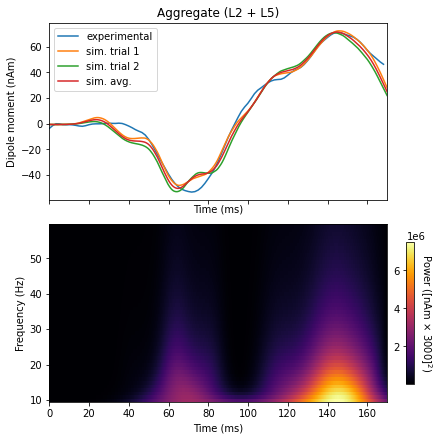

In [57]:
# plot simulated dipole time-frequency reponse (TFR)
# create matplotlib subplots on which to overlay hnn-core simulation plots
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                         constrained_layout=True)

# plot experimental dipole
exp_dpl.plot(ax=axes[0], show=False)

# plot both simulation trial dipoles and their avg
# note that there are two ways to plot a dipole: using the Dipole.plot() method and the plot_dipole() function!
plot_dipole(dpls, ax=axes[0], layer='agg', show=False)
average_dipoles(dpls).plot(ax=axes[0], show=False)
axes[0].legend(['experimental', 'sim. trial 1', 'sim. trial 2', 'sim. avg.'])

# finally, plot the TFR spectrogram
# note that it won't be very good given that our simulation is not long enough to resolve low frequencies
freqs = np.arange(10, 60)
n_cycles = 10 / freqs
fig = plot_tfr_morlet(dpls, ax=axes[1], freqs=freqs, n_cycles=n_cycles)

## 5. Creating higher-level functions that fit YOUR workflow

Here we'll define two new functions that will help streamline further exploration in this tutorial.

In [81]:
# a new function that simulates and smooths dipoles
def simulate_and_smooth(net_with_drives, n_trials=2, smoothing_window=30, scaling_factor=3000):
    with MPIBackend(n_procs=4):
        dpls = simulate_dipole(net_with_drives, tstop=170., n_trials=n_trials)

    for dpl in dpls:
        dpl.smooth(window_len).scale(scaling_factor)
    return dpls

In [97]:
# a new function that generates standard simulation plots
def plot_sim(net, dpls, exp_dpl=exp_dpl):
    # create matplotlib subplots on which to overlay hnn-core simulation plots
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6),
                             constrained_layout=True)

    # plot experimental dipole
    exp_dpl.plot(ax=axes[0], show=False)

    # plot both simulation trial-avg dipole
    average_dipoles(dpls).plot(ax=axes[0], show=False)

    axes[0].legend(['experimental', 'sim. avg.'])

    # finally, plot the input spike histogram
    fig = net.cell_response.plot_spikes_hist(ax=axes[1],
                                             spike_types=['evprox', 'evdist'])

## 6. Adjusting parameters

### 6.1 Changing the timing and strength (post-synaptic conductance) of the evoked inputs
For this part of the tutorial, we’ll load a different experimental dataset, at first keeping the simulation parameters that we started out with. The new experimental data represents the evoked response (ER) from non-detected threshold level stimuli in the experiment described in the introduction section above [1].

Once we load the new ER waveform, notice that the timing and magnitude of the peaks in this new  are different than for the ERs that were detected.

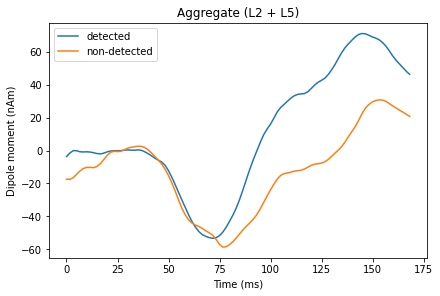

In [94]:
# retrieve and load the experimental dipole
data_url = ('https://raw.githubusercontent.com/jonescompneurolab/hnn/master/'
            'data/MEG_detection_data/no_trial_S1_ERP_all_avg.txt')
urlretrieve(data_url, 'no_trial_S1_ERP_all_avg.txt')
exp_dpl_nd = read_dipole('no_trial_S1_ERP_all_avg.txt')

# compare to previous experimental dipole
fig = exp_dpl.plot(show=False)
ax = fig.gca()
fig = exp_dpl_nd.plot(ax=ax, show=False)
ax.legend(['detected', 'non-detected'])
plt.show()

Given that the non-detection ER (orange) has peaks that occure slightly later and are decreased in magnitude, we will test the following hypotheses about its origin in relation to the detected ER:
1. The non-detected ER represents a decrease in the strength of the inputs that create the evoked response
2. The non-detected ER can be produced by a more delayed arrival time of these inputs to the network

In [95]:
net = jones_2009_model()

weights_ampa_d1['L2_basket'] += 0.002

# First, we add a distal evoked drive
weights_ampa_d1 = {'L2_basket': 6.28754, 'L2_pyramidal': 2.07922,
                   'L5_pyramidal': 0.00513}
# all NMDA weights are zero; pass None explicitly
net.add_evoked_drive(
    'evdist1', mu=72.1, sigma=5.0, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=None, location='distal',
    synaptic_delays=synaptic_delays_d1, event_seed=4)

# Then, we add two proximal drives
weights_ampa_p1 = {'L2_basket': 0.05551, 'L2_pyramidal': 0.01075,
                   'L5_basket': 0.20281, 'L5_pyramidal': 0.00024}
# all NMDA weights are zero; pass None explicitly
net.add_evoked_drive(
    'evprox1', mu=40.6, sigma=2.5, numspikes=1, weights_ampa=weights_ampa_p1,
    weights_nmda=None, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=4)

# Second proximal evoked drive. NB: only AMPA weights differ from first
weights_ampa_p2 = {'L2_basket': 0.00399, 'L2_pyramidal': 0.05121,
                   'L5_basket': 0.01305, 'L5_pyramidal': 0.37517}

# all NMDA weights are zero; omit weights_nmda (defaults to None)
net.add_evoked_drive(
    'evprox2', mu=144.7, sigma=14.2, numspikes=1,
    weights_ampa=weights_ampa_p2, location='proximal',
    synaptic_delays=synaptic_delays_prox, event_seed=4)

MPI will run over 4 processes
Running 2 trials...
numprocs=4
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 4 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Building the

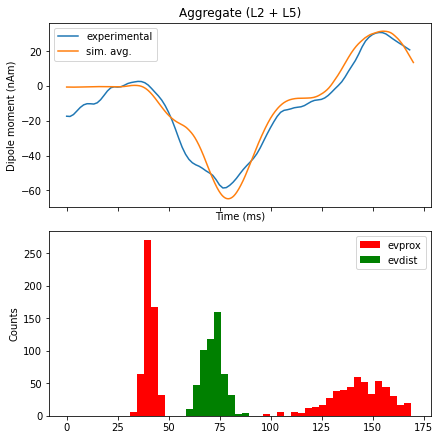

AttributeError: 'NoneType' object has no attribute 'gca'

In [100]:
dpls = simulate_and_smooth(net, n_trials=2)

fig = plot_sim(net, dpls, exp_dpl=exp_dpl_nd)

### 5.2 Drive parameter optimization

### 5.3 Exercises for further exploration

* Try adjusting the duration and strength of the distal drive; how does this affect the simulation?

* View the evoked responses for different values of the scaling parameter; how does this affect the simulation?

* View the evoked responses for different values of the smoothing parameter; how does this affect the simulation?

## 6. Extra info: asynchronous vs. synchronous drive
By default, HNN-Core provides an independently sampled spike train for each cell targetted by an exogenous drive. We call this an asynchonous drive because different cells receive asynchronous driving spikes. Let's try to make the exogenous driving inputs to the cells synchronous and see what happens. This can be accomplished in the model my specifying that each drive consists of only 1 artificial cell (i.e., a single source of spikes for the network) and delivers spike trains that are not cell-specific (i.e., they target all network cells).

In [84]:
# using the previously defined synaptic weight and delay values,
# we'll create a new network and add the same pattern of drives as before except with
# n_drive_cells=1 and cell_specific=False

net_sync = jones_2009_model()

n_drive_cells=1
cell_specific=False

net_sync.add_evoked_drive(
    'evdist1', mu=63.53, sigma=3.85, numspikes=1, weights_ampa=weights_ampa_d1,
    weights_nmda=weights_nmda_d1, location='distal', n_drive_cells=n_drive_cells,
    cell_specific=cell_specific, synaptic_delays=synaptic_delays_d1, event_seed=4)

net_sync.add_evoked_drive(
    'evprox1', mu=26.61, sigma=2.47, numspikes=1, weights_ampa=weights_ampa_p1,
    weights_nmda=None, location='proximal', n_drive_cells=n_drive_cells,
    cell_specific=cell_specific, synaptic_delays=synaptic_delays_prox, event_seed=4)

net_sync.add_evoked_drive(
    'evprox2', mu=137.12, sigma=8.33, numspikes=1,
    weights_ampa=weights_ampa_p2, location='proximal', n_drive_cells=n_drive_cells,
    cell_specific=cell_specific, synaptic_delays=synaptic_delays_prox, event_seed=4)

MPI will run over 4 processes
Running 2 trials...
numprocs=4
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 4 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Building the

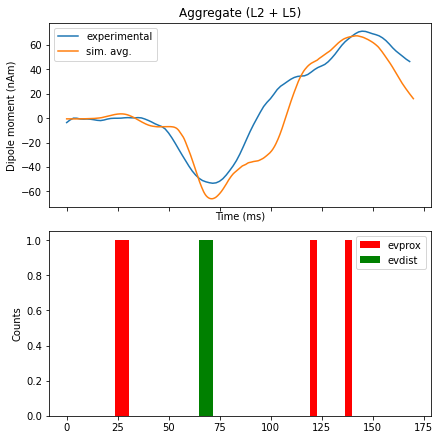

In [85]:
# now simulate with our custom higher-level functions
dpls = simulate_and_smooth(net_sync)

fig = plot_sim(net_sync, dpls)